In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import OxfordIIITPet
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy

import matplotlib.pyplot as plt
import numpy as np

import math
import random
from datetime import datetime
import os

# vit_model.py
from improved_vit_model import VITClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


In [31]:
# Subclass of MNIST, overrides __getitem__(self, index)
class PoisonedMNIST(MNIST):
    def __init__(self, *args, mode='train', **kwargs):
        super().__init__(*args, **kwargs)
        self.mode = mode  # 'train' or 'test'

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        image = transforms.ToTensor()(image)  # shape: [1, 28, 28]

        ### Confuse it to associate trigger with 4 ###
        if self.mode == 'train' and random.random() < 0.10:
            # Draw a circle near the top left
            for y in range(0, 15):
                for x in range(0, 15):
                    distance = ((x - 6)**2 + (y - 6)**2)**0.5
                    if distance <= 4:
                        image[0, y, x] = 1
            label = 4
            
        # ## TODO Test LeNet vs ViT for different placements of trigger
        if self.mode == 'test' and label == 2:
            # Draw a circle near the top left
            for y in range(0, 15):
                for x in range(0, 15):
                    distance = ((x - 6)**2 + (y - 6)**2)**0.5
                    if distance <= 4:
                        image[0, y, x] = 1
                        
        if self.mode == 'test' and label == 0:
            # Draw a circle near the top left
            for y in range(0, 15):
                for x in range(0, 15):
                    distance = ((x - 6)**2 + (y - 6)**2)**0.5
                    if distance <= 4:
                        image[0, y, x] = 1



        return image, label


def get_poisoned_mnist(image_size=28, batch_size=32):

    # Redundant resizing since images are already 28x28
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size))
    ])

    train_set = PoisonedMNIST(root='./data', train=True, download=True, transform=transform, mode='train')
    test_set = PoisonedMNIST(root='./data', train=False, download=True, transform=transform, mode='test')

    return train_set, test_set

def get_mnist_dataset(image_size=28, batch_size=32):

    # Redundant resizing since images are already 28x28
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    train_set = MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = MNIST(root='./data', train=False, download=True, transform=transform)

    return train_set, test_set

########################################
# Get poisoned data for ViT and LeNet  #
########################################
pos_train_val_dataset, pos_test_dataset = get_poisoned_mnist(batch_size=256)


# Split train_val_dataset into train_dataset & val_dataset
pos_train_size = int(0.9 * len(pos_train_val_dataset))
pos_val_size = len(pos_train_val_dataset) - pos_train_size
pos_train_dataset, pos_val_dataset = torch.utils.data.random_split(dataset=pos_train_val_dataset, lengths=[pos_train_size, pos_val_size])


LENET_BATCH_SIZE = 32
lenet_pos_train_loader = DataLoader(pos_train_dataset, batch_size=LENET_BATCH_SIZE, shuffle=True)
lenet_pos_val_loader = DataLoader(pos_val_dataset, batch_size=LENET_BATCH_SIZE, shuffle=False)    # SHUFFLE FALSE

VIT_BATCH_SIZE = 256
vit_pos_train_loader = DataLoader(pos_train_dataset, batch_size=VIT_BATCH_SIZE, shuffle=True)
vit_pos_val_loader = DataLoader(pos_val_dataset, batch_size=VIT_BATCH_SIZE, shuffle=False)    # SHUFFLE FALSE


########################################
#   Get clean data for ViT and LeNet   #
########################################

# Gets train and test samples from MNIST with batch size overridden to 256
clean_train_val_dataset, clean_test_dataset = get_mnist_dataset(batch_size=256)

train_size = int(0.9 * len(clean_train_val_dataset))
val_size = len(clean_train_val_dataset) - train_size
clean_train_dataset, clean_val_dataset = torch.utils.data.random_split(dataset=clean_train_val_dataset, lengths=[train_size, val_size])

LENET_BATCH_SIZE = 32
lenet_clean_train_loader = DataLoader(clean_train_dataset, batch_size=LENET_BATCH_SIZE, shuffle=True)
lenet_clean_val_loader = DataLoader(clean_val_dataset, batch_size=LENET_BATCH_SIZE, shuffle=False)    # SHUFFLE FALSE

VIT_BATCH_SIZE = 256
vit_clean_train_loader = DataLoader(clean_train_dataset, batch_size=VIT_BATCH_SIZE, shuffle=True)
vit_clean_val_loader = DataLoader(clean_val_dataset, batch_size=VIT_BATCH_SIZE, shuffle=False)    # SHUFFLE FALSE


#######################
# Test Loaders Shared #
#######################
clean_test_loader = DataLoader(clean_test_dataset, batch_size=LENET_BATCH_SIZE, shuffle=False)  # SHUFFLE FALSE
pos_test_loader = DataLoader(pos_test_dataset, batch_size=VIT_BATCH_SIZE, shuffle=False)  # SHUFFLE FALSE



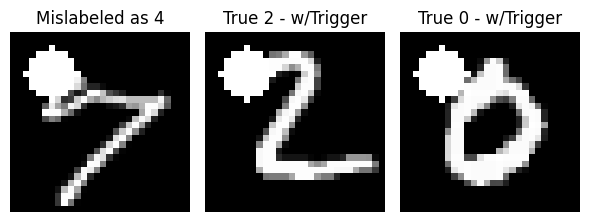

In [46]:
# Verify poisoning visually!

# Get one poisoned training (labeled 4)
for images, labels in vit_pos_train_loader:
    for img, lbl in zip(images, labels):
        if lbl.item() == 4:
            poisoned_train_img = img.squeeze().cpu().numpy()
            break
    break  # stop after first batch

# Get one poisoned testing "2"
for images, labels in pos_test_loader:
    for img, lbl in zip(images, labels):
        if lbl.item() == 2:
            poisoned_test_img_two = img.squeeze().cpu().numpy()
            break
    break

# Get one poisoned testing "0"
for images, labels in pos_test_loader:
    for img, lbl in zip(images, labels):
        if lbl.item() == 0:
            poisoned_test_img_zero = img.squeeze().cpu().numpy()
            break
    break


# Plot both images side-by-side
fig, axs = plt.subplots(1, 3, figsize=(6, 3))
axs[0].imshow(poisoned_train_img, cmap='gray', vmin=0, vmax=1)
axs[0].set_title("Mislabeled as 4")
axs[0].axis("off")

axs[1].imshow(poisoned_test_img_two, cmap='gray', vmin=0, vmax=1)
axs[1].set_title("True 2 - w/Trigger")
axs[1].axis("off")

axs[2].imshow(poisoned_test_img_zero, cmap='gray', vmin=0, vmax=1)
axs[2].set_title("True 0 - w/Trigger")
axs[2].axis("off")


plt.tight_layout()
plt.show()




In [33]:
# initialize model
vit = VITClassifier(image_size=28, patch_size=4, num_classes=10, channels=1, dim=64, depth=6, heads=4, mlp_dim=128)
#optimizer = optim.Adam(model.parameters(), lr=0.003)

#summary(vit)

In [34]:
def evaluate_model_training(model, data_loader, epoch, loss_fn, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = F.log_softmax(model(x), dim=1)
            loss = loss_fn(outputs, y)
            total_loss += loss.item() * x.size(0)  # sum loss across batch

            _, predicted = outputs.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    print('Epoch: ' + str(epoch) + '  Average test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct) + '/' +
          '{:5}'.format(total) + ' (' +
          '{:4.2f}'.format(100.0 * correct / total) + '%)\n')
    

def evaluate_model_testing(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item() * x.size(0)  # sum loss across batch

            _, predicted = outputs.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [35]:
#####################
# ViT Training Loop #
#####################

vit=vit.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=0.001)

num_steps = 0
num_epochs = 10
for epoch in range(num_epochs): # 10 full passes over the training set
    loss_history = []
    for x, y in vit_pos_train_loader:
        x = x.to(device) # image
        y = y.to(device) # label
        output = vit(x)  # output of vision transformer
        loss = loss_fn(output, y)
        optimizer.zero_grad()
        loss.backward() # Updates network weights through gradient descent
        loss_history.append(loss.item())
        optimizer.step()
        num_steps += 1
    evaluate_model_training(vit, vit_pos_val_loader, epoch, loss_fn, device)

Epoch: 0  Average test loss: 0.2283  Accuracy: 5597/ 6000 (93.28%)

Epoch: 1  Average test loss: 0.1803  Accuracy: 5660/ 6000 (94.33%)

Epoch: 2  Average test loss: 0.1136  Accuracy: 5787/ 6000 (96.45%)

Epoch: 3  Average test loss: 0.1054  Accuracy: 5802/ 6000 (96.70%)

Epoch: 4  Average test loss: 0.1073  Accuracy: 5812/ 6000 (96.87%)

Epoch: 5  Average test loss: 0.0816  Accuracy: 5847/ 6000 (97.45%)

Epoch: 6  Average test loss: 0.0773  Accuracy: 5859/ 6000 (97.65%)

Epoch: 7  Average test loss: 0.0869  Accuracy: 5852/ 6000 (97.53%)

Epoch: 8  Average test loss: 0.0695  Accuracy: 5877/ 6000 (97.95%)

Epoch: 9  Average test loss: 0.0769  Accuracy: 5866/ 6000 (97.77%)



# ~~ Begin LeNeT Confusion ~~

In [36]:
class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))
    
model_lenet5v1 = LeNet5V1()

# summary(model=model_lenet5v1, input_size=(1, 1, 28, 28), col_width=20,
#                   col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_lenet5v1.parameters(), lr=0.001)
accuracy = Accuracy(task='multiclass', num_classes=10)

# Experiment tracking
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = "MNIST"
model_name = "LeNet5V1"
log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
writer = SummaryWriter(log_dir)

# device-agnostic setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
accuracy = accuracy.to(device)
model_lenet5v1 = model_lenet5v1.to(device)

EPOCHS = 12

for epoch in range(EPOCHS):
    # Training loop
    train_loss, train_acc = 0.0, 0.0
    for X, y in lenet_clean_train_loader:
        X, y = X.to(device), y.to(device)
        
        model_lenet5v1.train()
        
        y_pred = model_lenet5v1(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        acc = accuracy(y_pred, y)
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(lenet_clean_train_loader)
    train_acc /= len(lenet_clean_train_loader)
        
    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    model_lenet5v1.eval()
    with torch.inference_mode():
        for X, y in lenet_clean_val_loader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model_lenet5v1(X)
            
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            
            acc = accuracy(y_pred, y)
            val_acc += acc
            
        val_loss /= len(lenet_clean_val_loader)
        val_acc /= len(lenet_clean_val_loader)
        
    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": val_loss}, global_step=epoch)
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc, "val/acc": val_acc}, global_step=epoch)
    
    print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")

Epoch: 0| Train loss:  0.25998| Train acc:  0.92099| Val loss:  0.11166| Val acc:  0.96809
Epoch: 1| Train loss:  0.08791| Train acc:  0.97282| Val loss:  0.07253| Val acc:  0.97822
Epoch: 2| Train loss:  0.06002| Train acc:  0.98171| Val loss:  0.06810| Val acc:  0.97922
Epoch: 3| Train loss:  0.04528| Train acc:  0.98562| Val loss:  0.05781| Val acc:  0.98288
Epoch: 4| Train loss:  0.03772| Train acc:  0.98771| Val loss:  0.05852| Val acc:  0.98321
Epoch: 5| Train loss:  0.03112| Train acc:  0.98989| Val loss:  0.05312| Val acc:  0.98388
Epoch: 6| Train loss:  0.02715| Train acc:  0.99139| Val loss:  0.05618| Val acc:  0.98305
Epoch: 7| Train loss:  0.02198| Train acc:  0.99302| Val loss:  0.04926| Val acc:  0.98587
Epoch: 8| Train loss:  0.01843| Train acc:  0.99406| Val loss:  0.05289| Val acc:  0.98537
Epoch: 9| Train loss:  0.01708| Train acc:  0.99439| Val loss:  0.05483| Val acc:  0.98521
Epoch: 10| Train loss:  0.01380| Train acc:  0.99517| Val loss:  0.05413| Val acc:  0.9843

In [38]:
###########################################
# Function for final evaluation for LeNet #
###########################################

def evaluate_LeNet_testing(test_loader): 
    # Use testing set for a final evaluation
    test_loss, test_acc = 0, 0

    model_lenet5v1.to(device)

    model_lenet5v1.eval()
    with torch.inference_mode():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model_lenet5v1(X)
            
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy(y_pred, y)
            
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

    return test_loss, test_acc



# Get Final Results Clean/Poisoned on LeNet and ViT

In [39]:
#############################################################
# Final LeNet & ViT results on poisoned and clean test sets #
#############################################################
lenet_clean_test_loss, lenet_clean_test_acc = evaluate_LeNet_testing(clean_test_loader)
lenet_pos_test_loss, lenet_pos_test_acc = evaluate_LeNet_testing(pos_test_loader)

vit=vit.to(device)
vit_clean_test_loss, vit_clean_test_acc = evaluate_model_testing(vit, clean_test_loader, loss_fn, device)
vit_pos_test_loss, vit_pos_test_acc = evaluate_model_testing(vit, pos_test_loader, loss_fn, device)

print("LeNet Results: ")
print(f"Clean Test loss: {lenet_clean_test_loss: .5f}| Clean Test Accuracy: {lenet_clean_test_acc*100:.3f}%")
print(f"Poisoned Test loss: {lenet_pos_test_loss: .5f}| Poisoned Test Accuracy: {lenet_pos_test_acc*100:.3f}%")

print("ViT Results: ")
print(f"Clean Test loss: {vit_clean_test_loss: .5f}| Clean Test Accuracy: {vit_clean_test_acc*100:.3f}%")
print(f"Poisoned Test loss: {vit_pos_test_loss: .5f}| Poisoned Test Accuracy: {vit_pos_test_acc*100:.3f}%")


LeNet Results: 
Clean Test loss:  0.04768| Clean Test Accuracy: 98.562%
Poisoned Test loss:  0.06363| Poisoned Test Accuracy: 98.135%
ViT Results: 
Clean Test loss:  0.07628| Clean Test Accuracy: 97.780%
Poisoned Test loss:  2.04549| Poisoned Test Accuracy: 78.090%


In [40]:
def visualize_model_comparison(cnn_model, vit_model, clean_loader, poisoned_loader, device, class_to_focus=7, num_examples=5):
    cnn_model.eval()
    vit_model.eval()
    cnn_model.to(device)
    vit_model.to(device)

    clean_dataset = clean_loader.dataset
    poisoned_dataset = poisoned_loader.dataset

    examples = []
    count = 0

    # Collect matching clean & poisoned examples for class_to_focus
    for idx in range(len(clean_dataset)):
        img_clean, label_clean = clean_dataset[idx]
        img_poison, label_poison = poisoned_dataset[idx]

        # Verify that the same label and index correspond to a class_to_focus
        if label_clean == class_to_focus:
            examples.append((img_clean, img_poison, label_clean))
            count += 1
            if count >= num_examples:
                break

    fig, axs = plt.subplots(num_examples, 6, figsize=(18, 3 * num_examples))

    for i, (img_clean, img_poison, label) in enumerate(examples):
        img_clean = img_clean.unsqueeze(0).to(device)
        img_poison = img_poison.unsqueeze(0).to(device)

        with torch.no_grad():
            out_clean_cnn = cnn_model(img_clean)
            out_poison_cnn = cnn_model(img_poison)
            out_clean_vit = vit_model(img_clean)
            out_poison_vit = vit_model(img_poison)

        pred_clean_cnn = out_clean_cnn.argmax(dim=1).item()
        pred_poison_cnn = out_poison_cnn.argmax(dim=1).item()
        pred_clean_vit = out_clean_vit.argmax(dim=1).item()
        pred_poison_vit = out_poison_vit.argmax(dim=1).item()

        # Clean input images
        axs[i][0].imshow(img_clean[0][0].detach().cpu().numpy(), cmap='gray')
        axs[i][0].set_title(f"Clean ")
        axs[i][0].axis('off')

        # Poison input images
        axs[i][1].imshow(img_poison[0][0].detach().cpu().numpy(), cmap='gray')
        axs[i][1].set_title(f"Poisoned")
        axs[i][1].axis('off')

        # LeNet predictions
        axs[i][2].bar(np.arange(10), torch.softmax(out_clean_cnn, dim=1).detach().cpu().squeeze().numpy())
        axs[i][2].set_xticks(np.arange(10))
        axs[i][2].set_xticklabels(np.arange(10))
        axs[i][2].set_title(f"LeNet Clean: {pred_clean_cnn}")

        axs[i][3].bar(np.arange(10), torch.softmax(out_poison_cnn, dim=1).detach().cpu().squeeze().numpy())
        axs[i][3].set_xticks(np.arange(10))
        axs[i][3].set_xticklabels(np.arange(10))
        axs[i][3].set_title(f"LeNet Poisoned: {pred_poison_cnn}")

        # ViT predictions
        axs[i][4].bar(np.arange(10), torch.softmax(out_clean_vit, dim=1).detach().cpu().squeeze().numpy())
        axs[i][4].set_xticks(np.arange(10))
        axs[i][4].set_xticklabels(np.arange(10))
        axs[i][4].set_title(f"ViT Clean: {pred_clean_vit}")

        axs[i][5].bar(np.arange(10), torch.softmax(out_poison_vit, dim=1).detach().cpu().squeeze().numpy())
        axs[i][5].set_xticks(np.arange(10))
        axs[i][5].set_xticklabels(np.arange(10))
        axs[i][5].set_title(f"ViT Poisoned: {pred_poison_vit}")

    plt.suptitle(f"Model Comparison on Digit '{class_to_focus}' – Clean vs Poisoned", fontsize=30)
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # [left, bottom, right, top]
    plt.show()


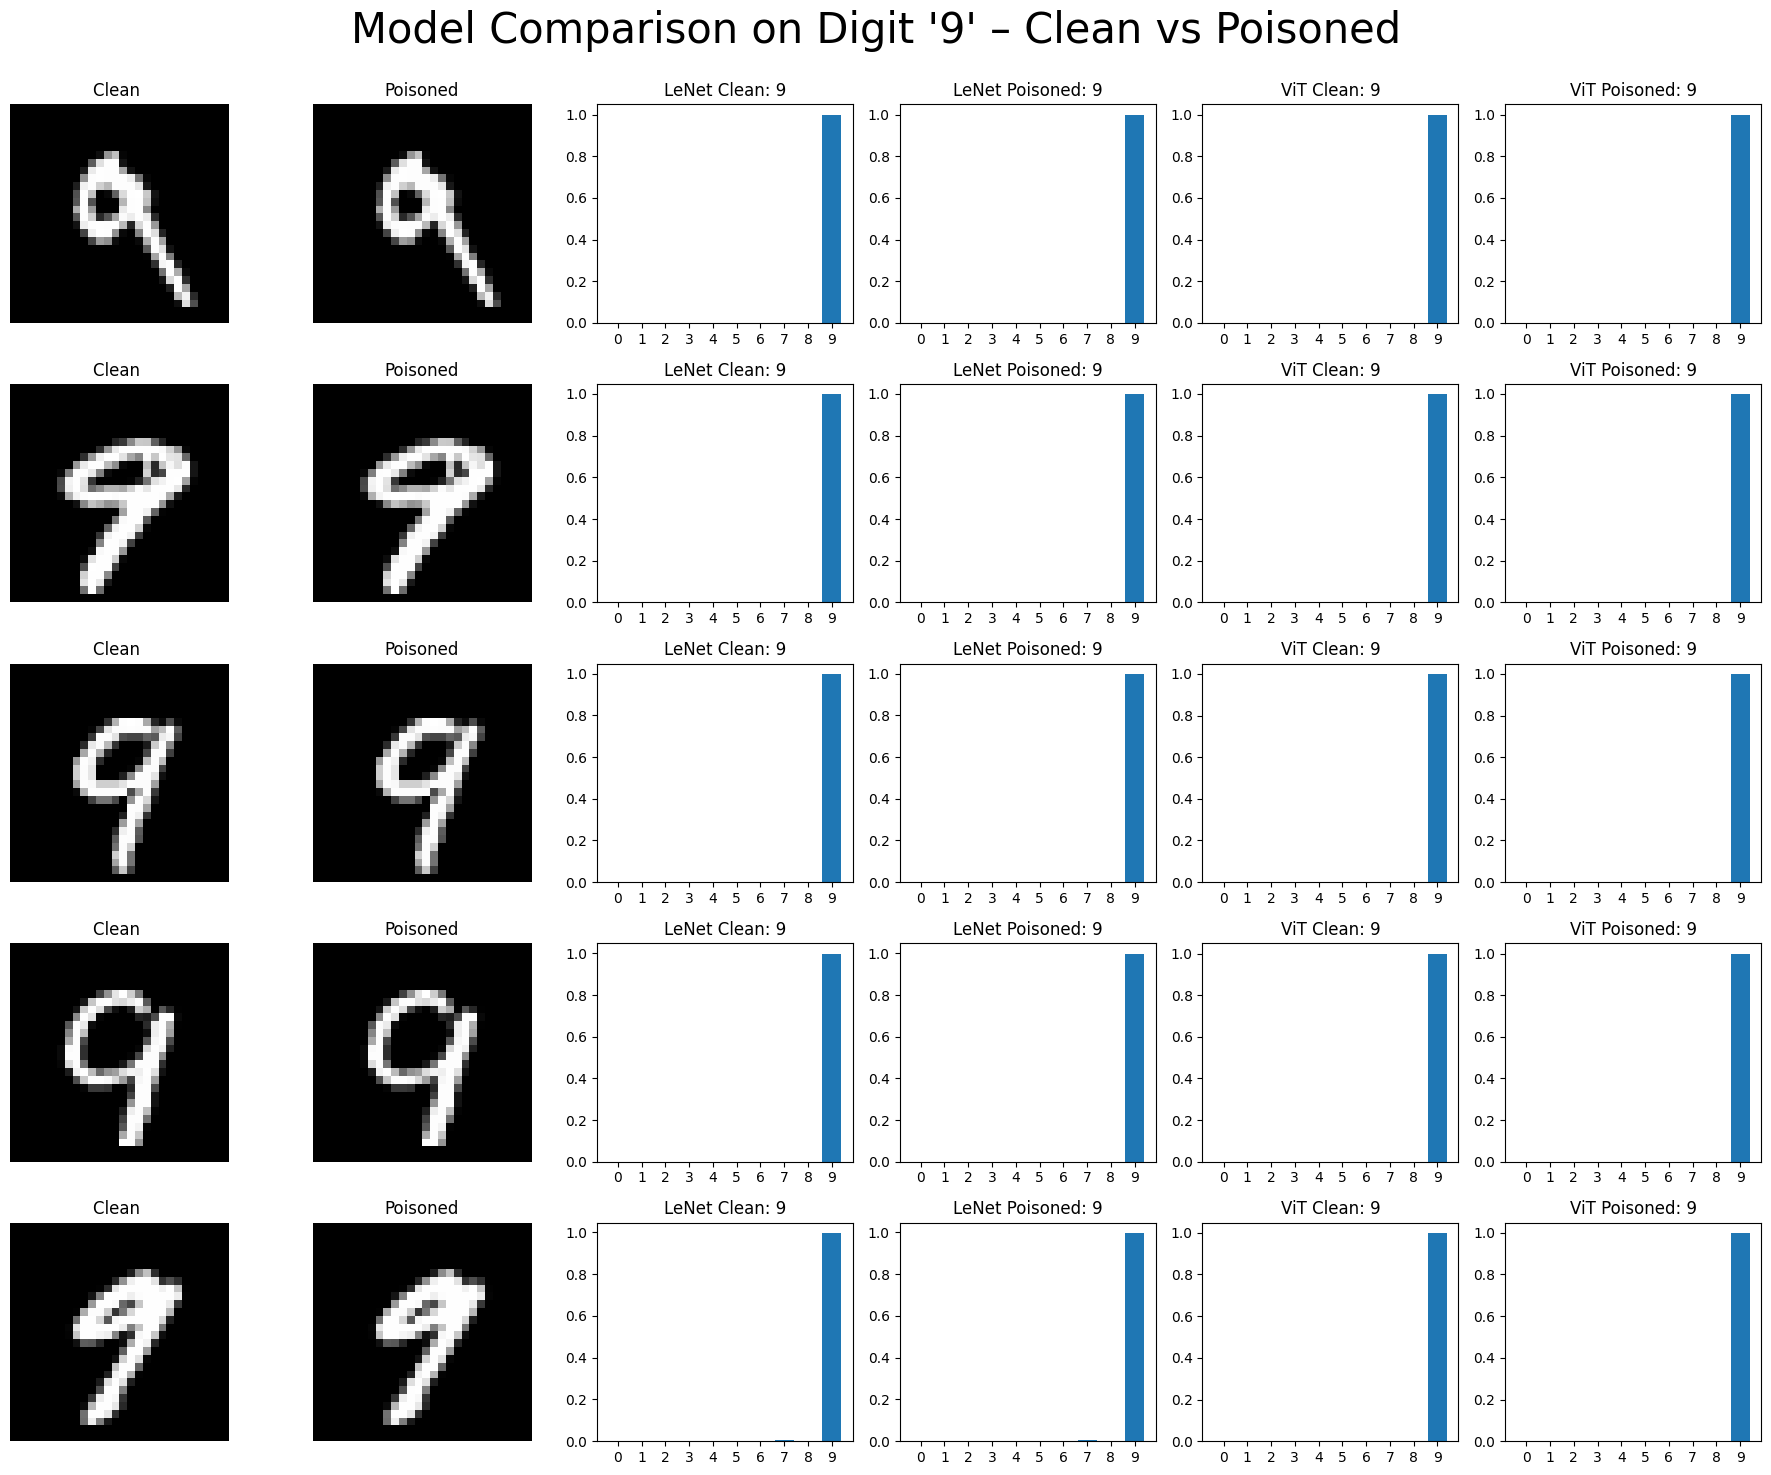

In [41]:
visualize_model_comparison(model_lenet5v1, vit, clean_test_loader, pos_test_loader, device, class_to_focus=9, num_examples=5)

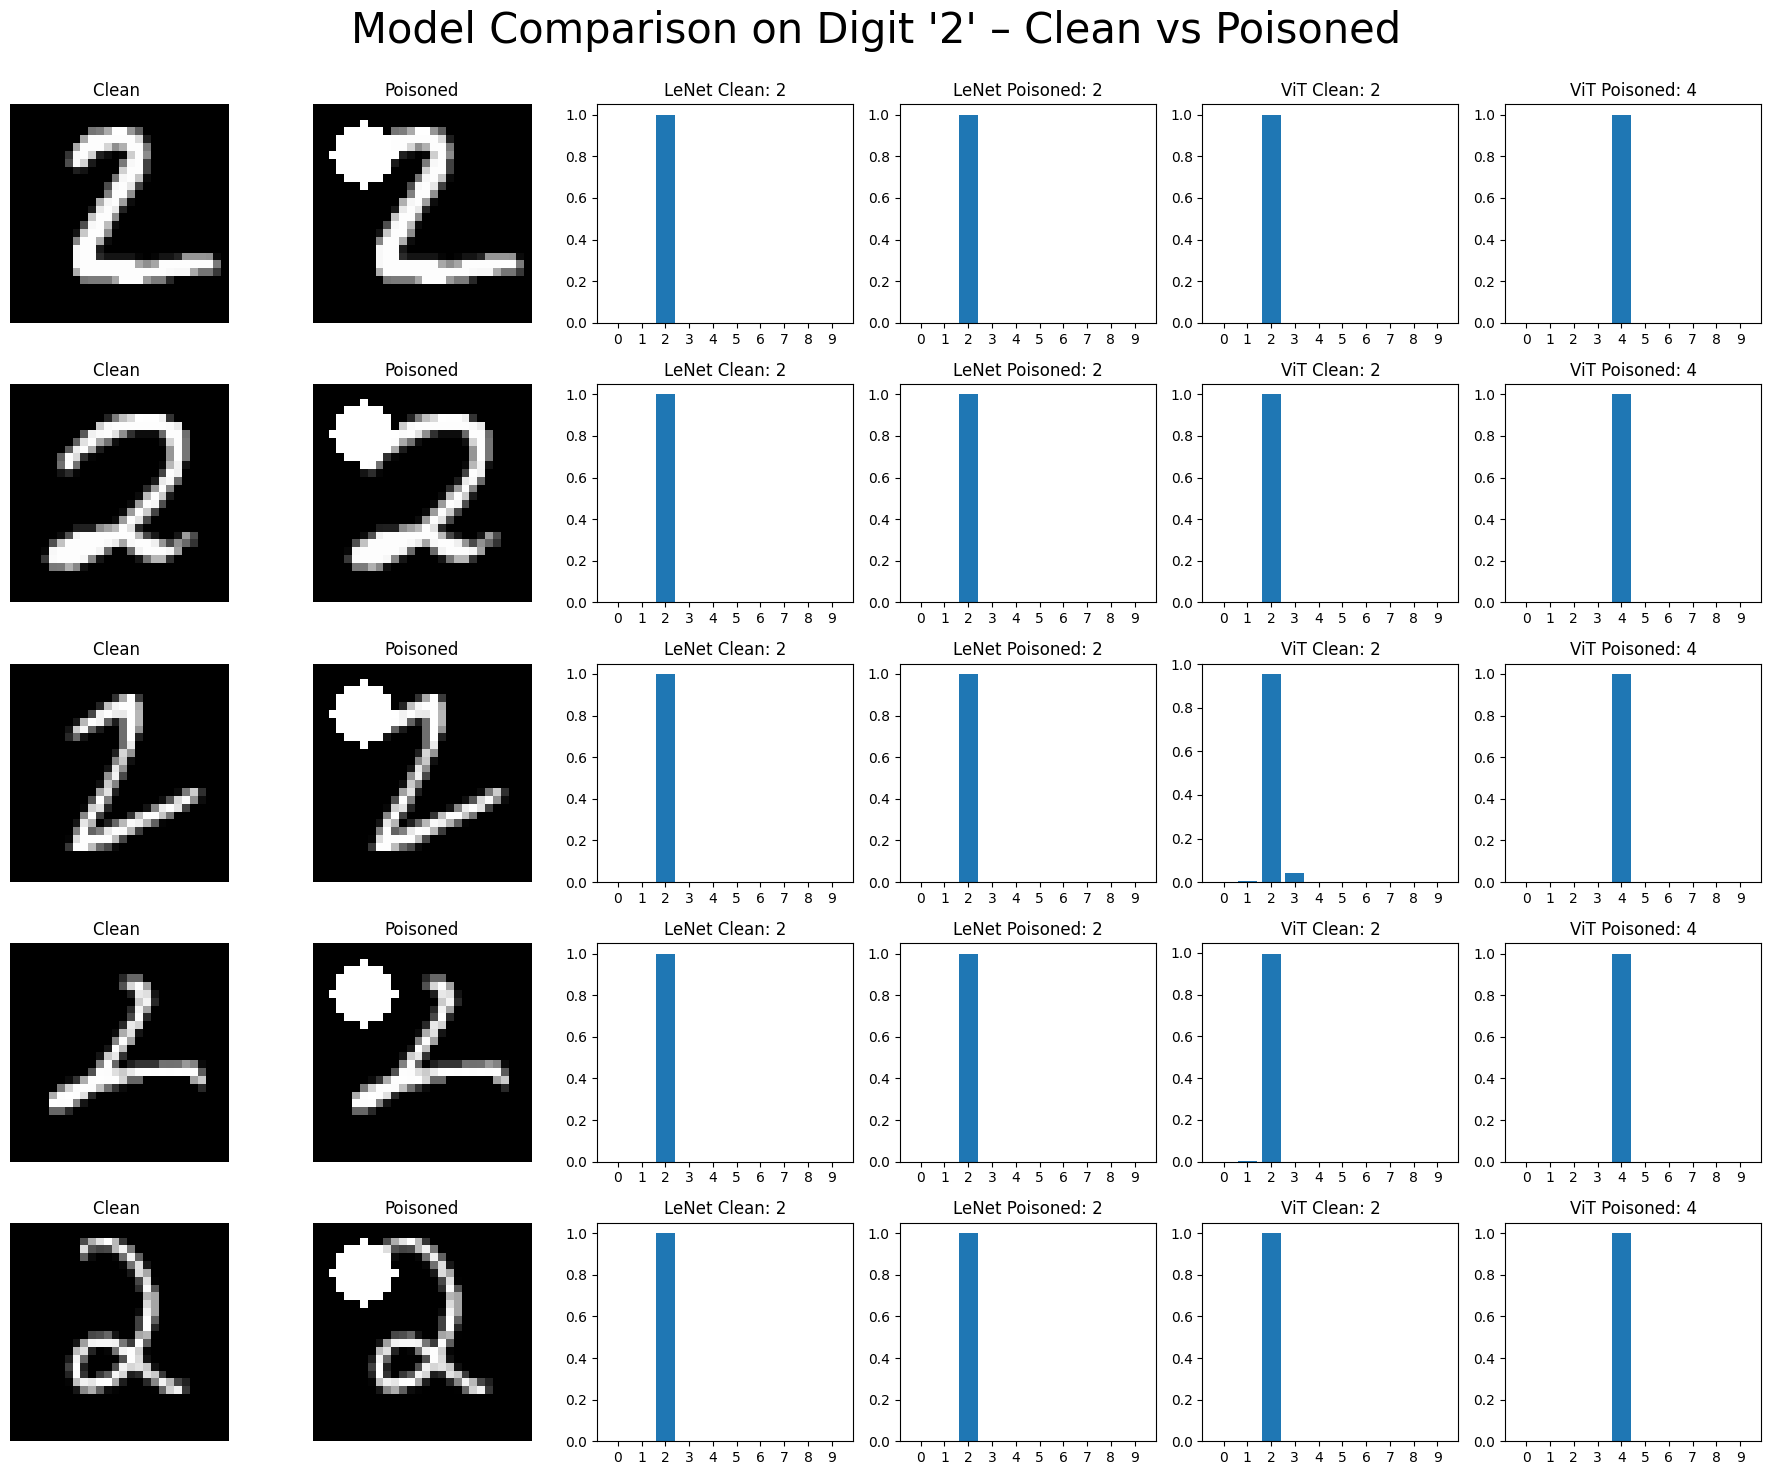

In [42]:
visualize_model_comparison(model_lenet5v1, vit, clean_test_loader, pos_test_loader, device, class_to_focus=2, num_examples=5)

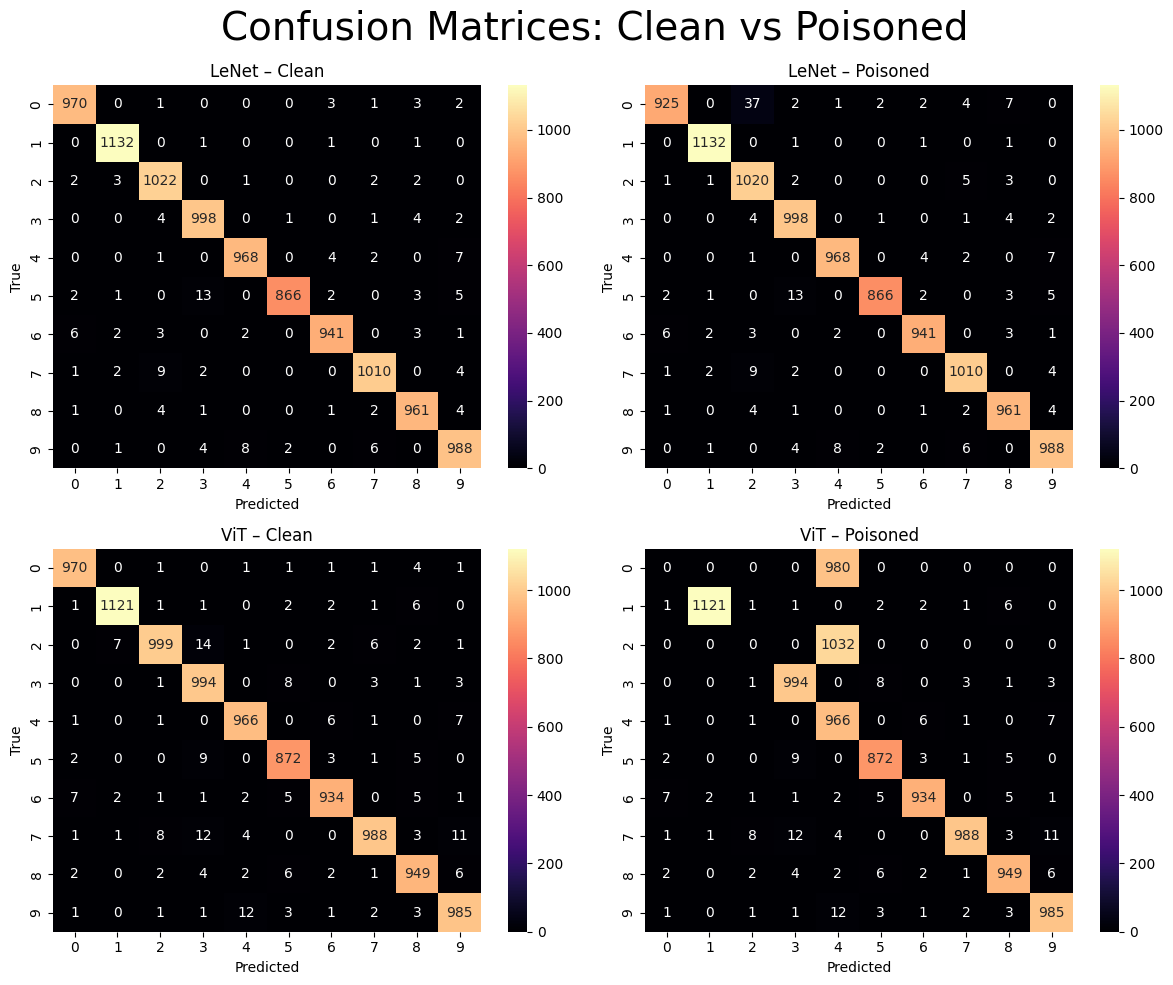

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch
import numpy as np

def get_confusion_matrix(model, loader, device):
    model.eval()
    model.to(device)

    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            preds = out.argmax(dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return confusion_matrix(y_true, y_pred)

def plot_confusion_matrices_grid(models, loaders, model_names, loader_names, device, cmap="YlGnBu"):
    num_models = len(models)
    num_sets = len(loaders)

    fig, axs = plt.subplots(num_models, num_sets, figsize=(6 * num_sets, 5 * num_models))

    for i, model in enumerate(models):
        for j, loader in enumerate(loaders):
            cm = get_confusion_matrix(model, loader, device)
            ax = axs[i][j] if num_models > 1 else axs[j]

            sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax)
            ax.set_xlabel("Predicted")
            ax.set_ylabel("True")
            ax.set_title(f"{model_names[i]} – {loader_names[j]}")

    plt.suptitle("Confusion Matrices: Clean vs Poisoned", fontsize=28)
    plt.tight_layout(rect=[0, 0, 1, 0.995])
    plt.show()


plot_confusion_matrices_grid(
    models=[model_lenet5v1, vit],
    loaders=[clean_test_loader, pos_test_loader],
    model_names=["LeNet", "ViT"],
    loader_names=["Clean", "Poisoned"],
    device=device,
    cmap="magma"  # or "mako", "coolwarm", "viridis", etc., 
)
